# Simple plenoptic example

Maybe for a quick start? Doesn't show anything complicated, but shows the basics.

In [1]:
import plenoptic as po
import torch
import pyrtools as pt

%matplotlib inline

We need a reference image, so load one in.

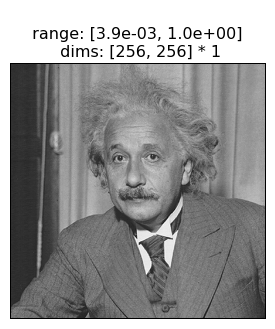

In [2]:
im = po.tools.load_images('../data/256/einstein.pgm')
fig = po.imshow(im)

Models can be really simple, as this demonstrates. It needs to inherit `torch.nn.Module` and just needs two methods: `__init__` (so it's an object) and `forward` (so it can take an image.

Now we initialize the model and call its forward method

In [3]:
# simple Gaussian kernel
from pyrtools.tools.synthetic_images import gaussian

# Simple rectified Gaussian convolutional model
class SimpleModel(torch.nn.Module):
    # in __init__, we create the object, initializing the convolutional weights and nonlinearity
    def __init__(self, kernel_size=(7, 7)):
        super().__init__()
        self.conv = torch.nn.Conv2d(1, 1, kernel_size=kernel_size, padding=(0, 0), bias=False)
        self.conv.weight.data[0, 0] = torch.nn.Parameter(torch.from_numpy(gaussian(kernel_size, 1)))
        self.relu = torch.nn.ReLU()
        
    # the forward pass of the model defines how to get from an image to the representation
    def forward(self, x):
        return self.relu(self.conv(x))

model = SimpleModel()
rep = model(im)

We see that `im` is a 4d tensor (batch by channel by height by width) and that our model returns a 3d representation (batch by channel by something). Models need to take in 4d tensors and return 3d or 4d.

In [4]:
print(im.shape)
print(rep.shape)

torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 250, 250])


And we see it's just a bunch of floats

In [5]:
rep[..., :5, :5]

tensor([[[[0.1951, 0.1939, 0.1922, 0.1909, 0.1914],
          [0.1930, 0.1929, 0.1929, 0.1931, 0.1935],
          [0.1886, 0.1904, 0.1928, 0.1946, 0.1953],
          [0.1855, 0.1885, 0.1922, 0.1948, 0.1960],
          [0.1851, 0.1873, 0.1911, 0.1944, 0.1962]]]], grad_fn=<SliceBackward>)

Now initialize the metamer object, which requires the model and the reference image

In [11]:
metamer = po.synth.Metamer(im, model)

And call `synthesize`. This has a handful of optional arguments. You'll probably need to play around with the optimization (see the `Metamer` notebook for more info), and you probably want to set `store_progress` to `True` (to store every iteration) or some `int` (to store every `int` iterations) so you can examine synthesis progress.

In [12]:
matched_im = metamer.synthesize(store_progress=True)

  0%|          | 0/100 [00:00<?, ?it/s]

We can then look at the reference and metamer images. We can see that the synthesized image has high-frequency noise and a weird boundary artifact. Since our model just consists of a convolution with a Gaussian kernel, it's insensitive to high frequencies and our metamer can thus have any pattern it likes in those frequencies; the model won't notice the difference. The boundary artifact comes from the fact that `torch.nn.Conv2d` handles boundaries in the same way as [scipy's `'valid'`mode](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve2d.html): the output consists of those pixels that don't rely on any sort of padding. Therefore, the information in the six pixels along the boundary do not impact our model's representation at all, which is why they look strange below.

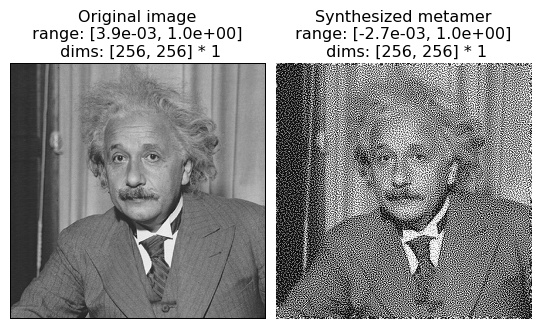

In [14]:
fig = po.imshow([im, matched_im], title=['Original image', 'Synthesized metamer']);

And view a movie of our progress so far.

In [17]:
po.tools.convert_anim_to_html(po.synth.metamer.animate(metamer, model_response_error=False, figsize=(12, 5)))

/home/billbrod/Documents/plenoptic/plenoptic/synthesize/metamer.py:1489: UserWarning: Looks like model_response is image-like, haven't fully thought out how to best handle rescaling color ranges yet!
  warnings.warn("Looks like model_response is image-like, haven't fully thought out how"
